# Object Tracking with Siamese Networks

In this session we will train a siamese network to optimize the euclidean distance between positive and negative image pairs. This will serve as a toy example of a tracking scenario, in which we need to match a set of detected objects in two consecutive frames. We will use MNIST dataset to train this network.

In [1]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

Using TensorFlow backend.


Here we define the loss function that we want to use, which uses the euclidean distance as metric. The loss is defined so that it minimizes the distance between positive pairs and maximizes it for negative pairs, with a certain margin.

In [2]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

We need to define the pairs of positives and negatives for training. A positive pair will be compose of two samples that belong to the same category. The function ```create_pairs``` will do this for us:

In [3]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    
    # number of samples per category
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            # z1 are positive pairs
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            # add the samples of z1 and x2 indices to pairs
            pairs += [[x[z1], x[z2]]]
            # select random sample from another category
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

Here we creat a simple architecture. This will be shared between the two samples in the pairs.

In [4]:
def create_base_network(input_dim):
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Dense(128, input_shape=(input_dim,), activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(128, activation='relu'))
    return seq

Since we defined a network with fully connected layers, we need to flatten the images as we did in the exercices from the first day.

In [5]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
input_dim = 784

Create positive and negative pairs for training and testing splits:

In [6]:
nb_epoch = 20

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = create_pairs(X_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(10)]
te_pairs, te_y = create_pairs(X_test, digit_indices)

Now we build the siamese network by reusing the base network we previously defined:

In [7]:
# network definition
base_network = create_base_network(input_dim)

input_a = Input(shape=(input_dim,))
input_b = Input(shape=(input_dim,))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

In order to use the loss we defined above, we need to create a layer that computes the euclidean distance between the output of the two network branches. The euclidean distance will be the output of the network, which is the input to the loss function.

In [8]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model = Model(input=[input_a, input_b], output=distance)

We are now ready to train:

In [9]:
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms)
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y),
          batch_size=128,
          nb_epoch=nb_epoch,
          verbose=2)

Train on 108400 samples, validate on 17820 samples
Epoch 1/20
7s - loss: 0.0958 - val_loss: 0.0397
Epoch 2/20
4s - loss: 0.0388 - val_loss: 0.0284
Epoch 3/20
4s - loss: 0.0276 - val_loss: 0.0266
Epoch 4/20
4s - loss: 0.0224 - val_loss: 0.0258
Epoch 5/20
4s - loss: 0.0194 - val_loss: 0.0227
Epoch 6/20
4s - loss: 0.0175 - val_loss: 0.0249
Epoch 7/20
4s - loss: 0.0158 - val_loss: 0.0230
Epoch 8/20
4s - loss: 0.0147 - val_loss: 0.0236
Epoch 9/20
4s - loss: 0.0136 - val_loss: 0.0231
Epoch 10/20
4s - loss: 0.0130 - val_loss: 0.0227
Epoch 11/20
4s - loss: 0.0125 - val_loss: 0.0210
Epoch 12/20
4s - loss: 0.0118 - val_loss: 0.0212
Epoch 13/20
4s - loss: 0.0117 - val_loss: 0.0209
Epoch 14/20
4s - loss: 0.0109 - val_loss: 0.0223
Epoch 15/20
4s - loss: 0.0108 - val_loss: 0.0226
Epoch 16/20
4s - loss: 0.0103 - val_loss: 0.0220
Epoch 17/20
4s - loss: 0.0101 - val_loss: 0.0226
Epoch 18/20
4s - loss: 0.0097 - val_loss: 0.0222
Epoch 19/20
4s - loss: 0.0095 - val_loss: 0.0227
Epoch 20/20
4s - loss: 0.00

Now we have our network trained and ready to be used on a toy tracking example. We will start by choosing some MNIST samples as if they were detected objects. 

We write a function to plot the samples we will select as detections:

In [10]:
import matplotlib.pyplot as plt  
%matplotlib inline

def plot_samples(samples):

    f, axarr = plt.subplots(1,samples.shape[0])
    for i in range(samples.shape[0]):
        
        im = np.reshape(samples[i],(28,28))
        axarr[i].imshow(im)
        axarr[i].axis('off')
    

    plt.show()

Now we will pick a different sample from each of the 10 different classes. These will be the detections on the two different frames, and we need to find a network to match them:

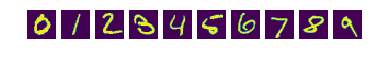

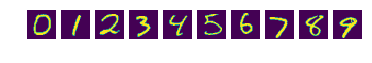

In [11]:
frame_1_idxs = []
frame_2_idxs = []

for i in range(len(digit_indices)):
    frame_1_idxs.append(digit_indices[i][0])
    frame_2_idxs.append(digit_indices[i][1])
frame_1_samples = X_test[frame_1_idxs,:]
frame_2_samples = X_test[frame_2_idxs,:]

plot_samples(frame_1_samples)
plot_samples(frame_2_samples)

Now let's create the extractor that we will use to extract the features from our network for all these samples:

In [12]:
model.layers

We need to forward our samples through the *Sequential* network within our model and get its output as the feature representation of our samples.

In [13]:
base_net = model.layers[2]

**Exercise:** Use ```base_net``` to extract features from detections in both frames (using the ```predict``` method):

In [14]:
feats_frame_1 = base_net.predict(frame_1_samples,batch_size=1,verbose=2)
feats_frame_2 = base_net.predict(frame_2_samples,batch_size=1,verbose=2)

**Exercise:** Given the two sets of features we just extracted, write the code to find the best match for each of the detections from frame 1 in frame 2. Check if the results are as you expected. Hint: you can use the function [euclidean_distances](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html) in scikit learn to quickly compute distances between feature vectors.

In [15]:
feats_frame_1.shape

(10, 128)

In [18]:
from sklearn.metrics.pairwise import euclidean_distances

dist = euclidean_distances(feats_frame_1,feats_frame_2)
dist.shape

np.argmin(dist,axis=0)
dist[0]

array([ 0.00160094,  1.38468301,  1.36476994,  1.3924005 ,  1.08718526,
        0.99038875,  0.95128036,  1.30669045,  1.04275012,  1.37115932], dtype=float32)

The idea here is that after computing the distances, we can see that minimum values are found in the positions where matching samples are found in the other set of detections.